# Image Classification for Malaria Detection



Acknowledgements
This Dataset is taken and from the official NIH Website: https://ceb.nlm.nih.gov/repositories/malaria-datasets/ and modified.


#### Portions of this page are modifications based on work created and shared by Google and used according to terms described in the Creative Commons 4.0 Attribution License and Apache License, version 2.0

### **Importing the Dataset**


In [1]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [2]:
!unzip "/content/gdrive/MyDrive/cell_images2.zip" -d cell_images/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_126.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_13.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_17.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_177.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_18.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_190.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_196.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_24.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_27.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_33.png  
 extracting: cell_images/train/Uninfected/C223ThinF_IMG_20151112_104708_cell_94.png  
 extracting: c

### Importing packages

In [3]:
import tensorflow as tf

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as imread
from IPython.display import clear_output
import os, sys
from PIL import Image 
import cv2
from matplotlib.pyplot import imread
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam, Adadelta
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization ,Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

2.4.1


In [4]:
test_path = '/content/cell_images/test/'
train_path = '/content/cell_images/train/'

In [5]:
image_size = (130, 130) #Image size

## Data Augmentation

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10, # Shift the pic width by a max of 5%
    height_shift_range=0.10, # Shift the pic height by a max of 5%
    rescale=1/255, # Rescale the image by normalzing it.
    shear_range=0.1, # Shear means cutting away part of the image (max 10%)
    zoom_range=0.1, # Zoom in by 10% max
    horizontal_flip=True, # Allo horizontal flipping
    fill_mode='nearest' # Fill in missing pixels with the nearest filled value
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=image_size,
    batch_size=16,
    color_mode='rgb',
    class_mode='binary'
)

validation_gen = datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=16,
    class_mode='binary',
    shuffle=False,
    color_mode='rgb'
)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [7]:
train_gen.class_indices   #Lables

{'Parasitized': 0, 'Uninfected': 1}

In [8]:
class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()
        
        self.logs = []
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('acc'))
        self.val_acc.append(logs.get('val_acc'))
        self.i += 1
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True)
        
        clear_output(wait=True)
        
        ax1.set_yscale('Log')
        ax1.plot(self.x, self.losses, label="loss")
        ax1.plot(self.x, self.val_losses, label="val_loss")
        ax1.legend()
        
        ax2.plot(self.x, self.acc, label="acc")
        ax2.plot(self.x, self.val_acc, label="val_acc")
        ax2.legend()
        
        plt.show()
        
        
plot = PlotLearning()

# Creating the Model

In [9]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=image_size+(3,), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
model.summary()  # Summary of the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

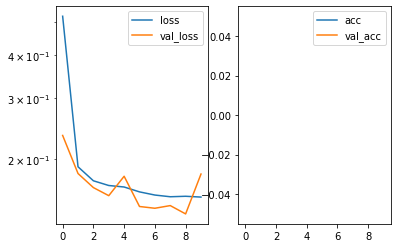

In [11]:
model.fit_generator(train_gen, epochs=10, callbacks=[plot], validation_data=validation_gen)

In [12]:
model.save('malariaModel.h5')

In [13]:
model.evaluate_generator(validation_gen)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.17771399021148682, 0.9465384483337402]

In [14]:
model.metrics_names

['loss', 'accuracy']